In [1]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorboard.plugins.beholder import Beholder
import math
import numpy as np

In [2]:
X_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))


X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [3]:
one_hot = {0:[1, 0],
           1:[0, 1]}

In [4]:
X_train.shape

(2000, 299, 299, 3)

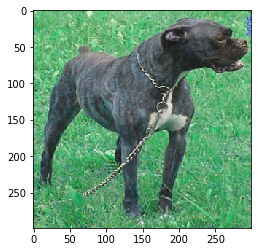

In [ ]:
plt.imshow(X_train[0])
plt.show()


In [ ]:
y_labels_test = []
y_labels_train = []
for y in y_test:
    y_labels_test.append(one_hot[y])
for y in y_train:
    y_labels_train.append(one_hot[y])

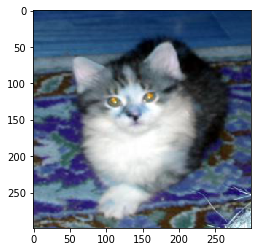

[1, 0]


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_test[5])

plt.show()
print(y_labels_test[5])

In [ ]:
LOGDIR = 'six'
BATCH_SIZE = 32
EPOCHS = 1000
LR = 0.5e-5
img_size_flat = 299 * 299 * 3
n_classes = 2

In [ ]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def network(x):
    with tf.name_scope("Reshape"):    
        x_image = tf.reshape(x, [-1, 268203])
    with tf.name_scope("Magic"):
        Y = tf.matmul(x_image, W) + B
    return Y

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="x")
    y = tf.placeholder(tf.float32, shape=[None, 2], name="labels")
    
with tf.name_scope("weight"):
    W = tf.Variable(tf.truncated_normal([img_size_flat, n_classes], stddev=0.5))
    tf.summary.histogram("weight", W)
with tf.name_scope("bias"):
    B = tf.Variable(tf.truncated_normal([1, n_classes], stddev=0.5))
    tf.summary.histogram("bias", W)

logits = network(x)

with tf.name_scope("xent"):
    xent = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits_v2(
                    labels=y, logits=logits), name="xent")
    tf.summary.scalar("xent", xent)
    
with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(LR, name='Adam').minimize(xent)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

with tf.name_scope("accuracy_val"):
    correct_prediction_val = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
    tf.summary.scalar("accuracy_val", accuracy_val)

summ = tf.summary.merge_all()

saver = tf.train.Saver()

with tf.Session(config=config) as sess:
        
    beholder = Beholder(LOGDIR)
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR)
    writer.add_graph(sess.graph)

    for i in range(EPOCHS):
        print(i)

        [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: X_train[0:700], y: y_labels_train[0:700]})
        [test_accuracy, s] = sess.run([accuracy_val, summ], feed_dict={x: X_test[0:700], y: y_labels_test[0:700]})
        writer.add_summary(s, i)

            
        for j in range(math.ceil(len(X_train) / BATCH_SIZE)):
            batch_x, batch_y = next_batch(num = BATCH_SIZE, data = X_train, labels = y_labels_train)
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y})
        beholder.update(session=sess)

    export_path =  './savedmodel6'
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)
    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(logits)

    prediction_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'x_input': tensor_info_x},
          outputs={'y_output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              prediction_signature 
      },
      )
    builder.save()
    sess.close()

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [1]:
# from keras.datasets import mnist
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
import pickle

X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [20]:
import tensorflow as tf
with tf.Session() as sess:
    signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    input_key = 'x_input'
    output_key = 'y_output'

    export_path =  './savedmodel6'
    meta_graph_def = tf.saved_model.loader.load(
               sess,
              [tf.saved_model.tag_constants.SERVING],
              export_path)
    signature = meta_graph_def.signature_def

    x_tensor_name = signature[signature_key].inputs[input_key].name
    y_tensor_name = signature[signature_key].outputs[output_key].name

    x = sess.graph.get_tensor_by_name(x_tensor_name)
    y = sess.graph.get_tensor_by_name(y_tensor_name)

    y_out = sess.run(y, {x: X_test})
    vars = tf.trainable_variables()
    print(vars) #some infos about variables...
    vars_vals = sess.run(vars)
    vizs = []
    for var, val in zip(vars, vars_vals):
        print("var: {}, value: {}".format(var.name, val))
        vizs.append(val)

INFO:tensorflow:Restoring parameters from ./savedmodel6\variables\variables
[<tf.Variable 'weight/Variable:0' shape=(268203, 2) dtype=float32_ref>, <tf.Variable 'bias/Variable:0' shape=(1, 2) dtype=float32_ref>, <tf.Variable 'weight/Variable:0' shape=(268203, 2) dtype=float32_ref>, <tf.Variable 'bias/Variable:0' shape=(1, 2) dtype=float32_ref>]
var: weight/Variable:0, value: [[ 0.27149048  0.27661094]
 [ 0.98086905 -0.25199822]
 [ 0.45463312 -0.13550551]
 ...
 [ 0.8783675  -0.3285196 ]
 [-0.01050528 -0.10625101]
 [-0.69426847  0.36865434]]
var: bias/Variable:0, value: [[ 0.40207994 -0.28684646]]
var: weight/Variable:0, value: [[ 0.27149048  0.27661094]
 [ 0.98086905 -0.25199822]
 [ 0.45463312 -0.13550551]
 ...
 [ 0.8783675  -0.3285196 ]
 [-0.01050528 -0.10625101]
 [-0.69426847  0.36865434]]
var: bias/Variable:0, value: [[ 0.40207994 -0.28684646]]


## Weights for Cat classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


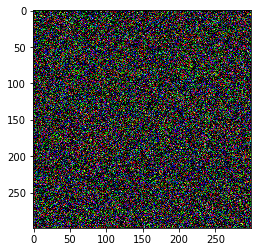

In [21]:
import numpy as np
z = []
for i in range(len(aaa[0])):
    z.append(vizs[0][i][0])
z = np.array(z)
bb = np.reshape(z, (299, 299, 3))
import matplotlib.pyplot as plt
plt.imshow(bb)

## Weights for Dog classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


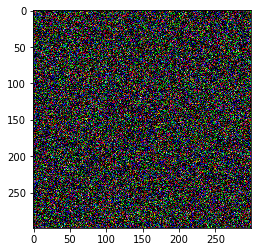

In [22]:
import numpy as np
z = []
for i in range(len(aaa[0])):
    z.append(vizs[0][i][1])
z = np.array(z)
bb = np.reshape(z, (299, 299, 3))
import matplotlib.pyplot as plt
plt.imshow(bb)

# If we look very closely we can see some patterns but the model isn't trained enough and the clcassification task is very hard for cat and dog

In [16]:
import numpy as np
predicted_values = []
for i in range(len(y_out)):
    index_max = np.argmax(y_out[i])
    predicted_values.append(index_max)

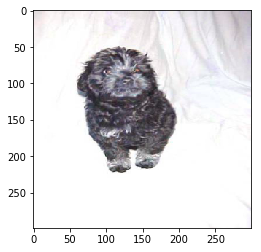

In [17]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
 # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.show()
plt.imshow(X_test[1], cmap="gray")
plt.show()

In [18]:
def classification_metrics(actual, pred, msg):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, pred)
    import seaborn as sns     

    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) 
    ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])   
    plt.show()       
    sensitivity = cm[1][1]/(cm[1][0] + cm[1][1])
    specifity = cm[0][0]/(cm[0][0] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    
    print(msg, '\n')
    print('accuracy:    ', round(accuracy,2), 
      '\nsensitivity: ', round(sensitivity,2), 
      '\nspecifity:   ', round(specifity,2))
#     from sklearn.metrics import classification_report
#     print(classification_report(actual, pred))
              


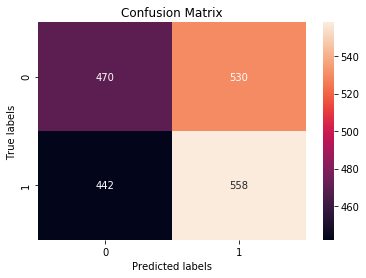

 

accuracy:     0.51 
sensitivity:  0.56 
specifity:    0.47


In [19]:
classification_metrics((y_test).astype(int), predicted_values, msg = '')